## <font color = "Navy"> This notebook is a comprehensive program used to collect ,clean and organize data for analysis

### <font color= "Indigo">Project Team:
<ol>
  <font color= "Indigo"><li>Subramanian Padmanabhan</li>
  <li>Kayalvizhi Vellaichamy</li>
  <li>Snigdha Enumulapally</li>
    <li>Gayathri Shanmugam</li>
    <li>Samhitha Pallelamudi</li>
    <li>Manushree Thimmaiah Sannathimmappa</li>
</ol>

# <font color = "Teal "> Part 1 : Data Collection

### <font color = "teal"> Web Scraping from Homes.com and AreaVibes.com

### <font color = 'teal'> Import required libraries

In [3]:
import pandas as pd
import numpy as np
import re
import requests
import json
import ssl
from bs4 import BeautifulSoup as BS
from urllib.request import Request, urlopen
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### <font color = 'teal'> Retrieve the data from Homes.com URL

In [2]:
def get_html_soup(url):
  soup=""
  text = requests.get(url).text
  soup = BS(text, "html5lib")
  return soup

parent_url= "https://www.homes.com"
california_homes_url = "https://www.homes.com/california/homes-for-sale/"
soup = get_html_soup(california_homes_url)

### <font color = 'teal'>Retrieve URL with house details present in State : California

In [3]:
all_cities_states_div = soup.find_all('div', attrs={'class':'optimized-links my-4 svelte-1l0ilm6'})
flag=False
for child in all_cities_states_div:
  if(child.find('h4').text=="More California Homes For Sale Near Me"):
    child_links=child.find_all('a')
    for x in child_links:
      if(x.text=="All California Cities with Homes for Sale"):
         soup = get_html_soup(parent_url+x['href'])
         all_cities_site_map_div = soup.find_all('div', attrs={'id':'html_sitemap'})
         break
  if flag==True:
    break

### <font color = 'teal'> Retrieve the URLs for the required cities in State : California

In [4]:
list_of_cities=['South San Francisco',
          'San Mateo',
          'Burlingame',
          'San Jose',
          'Palo Alto',
          'Santa Clara',
          'Cupertino',
          'Milpitas',
          'Fremont',
          'Union City',
          'Hayward',
          'Castro Valley',
          'Berkeley',
          'Oakland',
          'Pleasanton',
          'Dublin',
          'San Ramon',
          'Danville' ]

In [5]:
city_list=[]
for city in list_of_cities:
    for a in  soup('a'):
        if a.has_attr('href') and a.text.find(city) != -1:
            if a.text.find("East Palo Alto")!=-1:
              continue
            city_list.append(parent_url+a['href'])
            break


print(city_list)

['https://www.homes.com/south-san-francisco-ca/homes-for-sale/', 'https://www.homes.com/san-mateo-ca/homes-for-sale/', 'https://www.homes.com/burlingame-ca/homes-for-sale/', 'https://www.homes.com/san-jose-ca/homes-for-sale/', 'https://www.homes.com/palo-alto-ca/homes-for-sale/', 'https://www.homes.com/santa-clara-ca/homes-for-sale/', 'https://www.homes.com/cupertino-ca/homes-for-sale/', 'https://www.homes.com/milpitas-ca/homes-for-sale/', 'https://www.homes.com/fremont-ca/homes-for-sale/', 'https://www.homes.com/union-city-ca/homes-for-sale/', 'https://www.homes.com/hayward-ca/homes-for-sale/', 'https://www.homes.com/castro-valley-ca/homes-for-sale/', 'https://www.homes.com/berkeley-ca/homes-for-sale/', 'https://www.homes.com/oakland-ca/homes-for-sale/', 'https://www.homes.com/pleasanton-ca/homes-for-sale/', 'https://www.homes.com/dublin-ca/homes-for-sale/', 'https://www.homes.com/san-ramon-ca/homes-for-sale/', 'https://www.homes.com/danville-ca/homes-for-sale/']


In [6]:
# code to check wheteher a value is empty
def check_if_value_exists(tag_detail):
  value=""
  if(tag_detail and tag_detail.text):
    value=tag_detail.text
  return value

In [7]:
# function to retrieve all the areas of interest like colleges, airports etc. for each house
def get_count_of_each_point_of_interest(soup,last_character):
  count=0
  places_under_catergory_count=0
  while(True):
    data_testid="poi-name-"+str(last_character)+"-"+str(count)
    
    if soup.find('div',attrs={'data-testid':data_testid}) and soup.find('div',attrs={'data-testid':data_testid}).text!="None":
      places_under_catergory_count+=1
      count+=1
    else:
      break
  return places_under_catergory_count

In [8]:
# function to get the category of the point of interest
def check_category_name(soup,category):
  dict={}
  if(category and category.text!="None"):
    dict[category.text]=get_count_of_each_point_of_interest(soup,category.attrs['data-testid'][-1])
  return dict

In [9]:
# function to get public schools count
def get_public_schools_count(soup):
  school_count=0
  public_schools_count=0
  while(True):
    data_testid="school-card-"+str(school_count)
    if soup.find('li',attrs={'data-testid':data_testid}) and soup.find('li',attrs={'data-testid':data_testid}).text!="None":
        public_schools_count+=1
        school_count+=1
    else:
      break
  return public_schools_count


### <font color = 'teal'>Code to retrieve all the relevant columns

In [10]:
prop_list=[]
for cityurl in city_list:
    soup = get_html_soup(cityurl)
    pagenumber_listArray = soup.find('div',attrs={'class':"flex items-center justify-center font-weight-regular font-color-gray"}).contents
    pagenumber_list= pagenumber_listArray[len(pagenumber_listArray)-1]
    pgnb=int(pagenumber_list) + 1
    #if(pgnb>15):
    #    pgnb=15
    for x in range(1,pgnb):        
        urlwithpagenumber = cityurl+"p"+str(x)        #ADDING PAGE NUMBER TO URL
        soup = get_html_soup(urlwithpagenumber)
        if(soup):
          content_list = soup.findAll('a',attrs={'data-testid':"addr-ob-link"})

          url_list =[]
          for tag in content_list:
              suburl= parent_url + tag.attrs['href']#GETTING THE HOUSES URL FROM EACH PAGE
              url_list.append(suburl)        
            
          for url in url_list:
              soup1 = get_html_soup(url)
              propertydet1 = soup1.find('div',attrs={'class':"border-1 border-gray-lighter radius-6 p-1 bg-white box-shadow"})
              if propertydet1:
                propert1 ={}
                #price column
                propert1['Price'] = check_if_value_exists(propertydet1.find('h3',attrs={'class':"mb-1/4 font-size-xxl font-weight-regular"}))
                #beds column
                propert1['Beds'] = check_if_value_exists(propertydet1.find('span',attrs={'data-testid':"propertyDetails-Beds"}))
                #baths column
                propert1['Baths']= check_if_value_exists(propertydet1.find('span',attrs={'data-testid':"propertyDetails-Baths"}))
                #square feet column
                propert1['Sq.Ft'] = check_if_value_exists(propertydet1.find('span',attrs={'data-testid':"propertyDetails-Sqft"})) 
                #address column          
                propert1['Address_Line_1'] = check_if_value_exists(propertydet1.find('p',attrs={'class':"mb-1/4 py-0 font-size-l font-weight-light truncate"}))
                #city,state,zip column
                propert1['City_State_Zipcode'] =check_if_value_exists(propertydet1.find('p',attrs={'class':"py-0 font-size-l font-weight-light truncate"}))               
                propertydet2 = soup1.find('section',attrs={'class':"listing-agent-mini mt-1 border-t border-gray-lighter pt-1 font-size-l"})
                #agent name and company
                if propertydet2:
                    propert1['Agent_Name']=check_if_value_exists(propertydet2.find('div',attrs={'class':"mb-1/4"}))
                    propert1['Agent_Company'] =check_if_value_exists(propertydet2.find('div',attrs={'class':"mb-1/4 font-weight-light"}))

                #listing type and estimated monthly payment column
                propertydet3 = soup1.findAll('section',attrs={'class':"summary mb-1 border-b border-gray-lighter pb-1"})[0]
                arrListingType = propertydet3.find('div',attrs={'class':"mb-1/2 font-size-l"})
                propert1['Listing_Type'] = arrListingType.find('span').contents[0]
                propert1['Estimated_monthly_payment'] = check_if_value_exists(propertydet3.find('span',attrs={'class':"monthly-payment flex items-center font-color-blue pointer"}))

                #set all points of interest count to 0
                points_of_interest_list=["Airports","Colleges","Military Bases","Shopping Centers","Parks and Recreation"]
                for i in points_of_interest_list:
                  propert1[i]=0
                #find the main poitn of interest tag
                all_points_of_interest = soup1.find('div',attrs={'data-testid':"poi-drawer-body"})
                places_interest_dict={}
                no_categories_points_of_interest=5   #airports,colleges,Military Bases,Parks and Recreation,Shopping Centers
                for i in range(no_categories_points_of_interest):
                  data_testid="poi-category-"+str(i)
                  if(check_category_name(soup1,soup1.find('h4',attrs={'data-testid':data_testid}))):
                    places_interest_dict.update(check_category_name(soup1,soup1.find('h4',attrs={'data-testid':data_testid})))    
                      
                propert1.update(places_interest_dict)
                #get details of public school
                propert1["Public_Schools"]=get_public_schools_count(soup1)
                
                propert1["Utilities"] = 0
                propert1["HOA"]=False
                propert1["Parking"]=False
                propert1["Garage"]=False
                propert1["Pool"]=False
                propert1["Laundry"]=False
                propert1["Pets Allowed"]=False
                propert1["Kitchen Features"] = 0
                
                homeDetails = soup1.findAll('div',attrs={'data-testid':re.compile(r"^home-details-cat[0-9]-subcat[0-9]$")})

                for prop in homeDetails:
                    lis = prop.findAll('li')
                    if("Utilities" in check_if_value_exists(prop.find('h4',attrs={'class':"mb-1/2 font-weight-regular"}))):
                        propert1["Utilities"]=int(len(lis))
                
                    if("HOA" in check_if_value_exists(prop.find('h4',attrs={'class':"mb-1/2 font-weight-regular"}))and len(lis)>0):
                        propert1["HOA"]=True
                
                    if("Parking" in check_if_value_exists(prop.find('h4',attrs={'class':"mb-1/2 font-weight-regular"})) and len(lis)>0):
                        propert1["Parking"]=True
                        for li in lis:
                            if("Garage" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")})):
                                propert1["Garage"]=True
            
            
                    if("General" in check_if_value_exists(prop.find('h4',attrs={'class':"mb-1/2 font-weight-regular"}))):
                        for li in lis:
                            if(("Pool" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")}).text) 
                               and ("Yes" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")}).text)):
                                propert1["Pool"]=True
                            if("Laundry Features" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")})):
                                propert1["Laundry"]=True
                            if(("Pets" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")}).text)
                              and ("Yes" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")}).text)):
                                propert1["Pets Allowed"]=True
                        
                    if("Rooms" in check_if_value_exists(prop.find('h4',attrs={'class':"mb-1/2 font-weight-regular"}))):
                        for li in lis:
                            if("Kitchen Features" in li.find('span', attrs = {'data-testid':re.compile(r"^.*$")})):
                                propert1["Kitchen Features"]= str(li.find('span', attrs = {'data-testid':re.compile(r"^.*$")}).text.count(",") + 1)
            
                prop_list.append(propert1)  
              

In [11]:
homes_data_frame = pd.DataFrame(prop_list)
homes_data_frame

,Price,Beds,Baths,Sq.Ft,Address_Line_1,City_State_Zipcode,Agent_Name,Agent_Company,Listing_Type,Estimated_monthly_payment,...,Parks and Recreation,Public_Schools,Utilities,HOA,Parking,Garage,Pool,Laundry,Pets Allowed,Kitchen Features
0,"$749,000",1 Bed,1 Bath,935 Sq. Ft.,1 Mandalay Place Unit 702,"South San Francisco, CA 94080",Elana Bennett,Coldwell Banker Realty,Condo,"$3,537/mo",...,0,3,3,False,True,True,False,False,False,0
1,"$1,398,000",3 Beds,2 Baths,"1,500 Sq. Ft.",306 Avalon Drive,"South San Francisco, CA 94080",Anthony Batshon,Batshon Real Estate Company,House,"$6,603/mo",...,0,3,1,True,False,False,True,False,False,2
2,"$949,000",2 Beds,1 Bath,800 Sq. Ft.,709 W Orange Ave,"South San Francisco, CA 94080",Daniel Choi,Coldwell Banker Realty,House,"$4,482/mo",...,0,3,4,False,True,True,False,False,False,0
3,"$1,805,000",4 Beds,3 Baths,"2,000 Sq. Ft.",814 Miller Ave,"South San Francisco, CA 94080",Maryann Ernst,KW Peninsula Estates,House,"$8,525/mo",...,0,3,2,False,False,False,False,True,False,2
4,"$798,000",2 Beds,2 Baths,"1,252 Sq. Ft.",45 Appian Way A,"South San Francisco, CA 94080",Rebecca Molano,Redfin,House,"$3,769/mo",...,0,3,2,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,"$4,500,000",4 Beds,6 Baths,"7,010 Sq. Ft.",901 Eagle Ridge Dr,"Danville, CA 94506",Emily Dumdumaya,RE/MAX Gold,House,"$21,253/mo",...,0,3,0,False,False,False,False,False,False,0
1880,"$1,350,000",,,,2467 Diablo Ranch Pl,"Danville, CA 94506",Ben Dianda,Equidy,Lot/Land,"$6,376/mo",...,0,3,1,True,False,False,False,False,False,0
1881,"$5,950,000",3 Beds,3 Baths,"1,200 Sq. Ft.",7000 Camino Tassajara,"Danville, CA 94588",Douglas Manful,"Black Book International, Inc",House,"$28,101/mo",...,0,3,3,True,True,True,True,True,False,2
1882,"$4,995,000",5 Beds,5 Baths,"5,000 Sq. Ft.",3100 Finley Rd,"Danville, CA 94588",Douglas Manful,"Black Book International, Inc",House,"$23,591/mo",...,0,3,3,False,True,True,True,True,False,10


In [12]:
homes_data_frame.to_csv("House_details.csv", index = False, header = True)
homes_data_frame.shape

(1884, 24)

### <font color = "teal"> Web Scraping from AreaVibes.com

### <font color = 'teal'> Below code extracts information on vibes of a city

In [13]:
city_ratings = pd.DataFrame(columns=['Livability',
                                     'Amenities',
                                     'Cost of Living',
                                     'Crime',
                                     'Employment',
                                     'Housing',
                                     'Schools',
                                     'User Ratings'])
r = {}

In [14]:
# Function to get soup object
def extract_ratings(soup, city):
    for i in soup.find_all('nav',class_="category-menu-new"):
        print(i)
        x = i.find_all('em')
        y = i.find_all('i')
        for m in list(zip(x,y)):
            r.update({m[0].text:m[1].text})
    return r

In [19]:
def html(url):
    
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    
    header = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36" ,}
    
    # Making the website believe that we are accessing website using a mozilla browser
    req = Request(url, headers=header)
    webpage = urlopen(req).read()

    # Creating a BeautifulSoup object and parsing data with lxml
    soup = BS(webpage, 'html.parser')
    return soup

### <font color ='teal'> Get ratings for all the cities

In [20]:
for i in list_of_cities:
    try:
        soup = html(f'https://www.areavibes.com/{i.replace(" ","%20")}-ca/livability/')
        print(soup)
        city_ratings = city_ratings.append(pd.DataFrame(extract_ratings(soup,i),index=[i]))
    except:
        pass
  
display(city_ratings)

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

<!DOCTYPE html>

<html lang="en">
<head data-placement="w1w2w3w4w5">
<link crossorigin="" href="https://fonts.gstatic.com" rel="preconnect"/>
<link as="style" href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="preload"/>
<link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" media="print" onload="this.media='all'" rel="stylesheet"/>
<noscript><link href="https://fonts.googleapis.com/css2?family=Lato:wght@700&amp;family=Open+Sans:wght@400;600&amp;display=swap" rel="stylesheet"/></noscript>
<link crossorigin="" href="https://cdnjs.cloudflare.com" rel="preconnect"/>
<script>
    window.cmWrapper = window.cmWrapper || {};
    window.cmWrapper.que = window.cmWrapper.que || [];
    window.cmLinkWrapper = window.cmLinkWrapper || {};
    window.cmLinkWrapper.que = window.cmLinkWrapper.que || [];

    window.ga = window.ga || function(){(ga.q=ga.q||[]).push(argument

,Livability,Amenities,Cost of Living,Crime,Employment,Housing,Schools,User Ratings
South San Francisco,69,A+,F,C+,C+,C,D+,C+
San Mateo,75,A+,F,C+,B+,C+,B-,B
Burlingame,81,A+,F,D,A,B,A,A+
San Jose,67,A+,F,D,C+,C-,D,C+
Palo Alto,80,A+,F,C+,A+,C+,A+,B+
Santa Clara,77,A+,F,B-,B+,B,B+,B-
Cupertino,83,A+,F,A,A-,C+,A+,A-
Milpitas,74,A+,F,B-,B-,C-,C+,A
Fremont,76,A+,F,B-,B+,C+,A-,B-
Union City,67,A+,F,C-,C+,C-,B-,C-


In [21]:
city_ratings.to_csv("city_ratings.csv")

# <font color = 'RebeccaPurple '> Part 2 : Data Cleaning

### <font color = 'RebeccaPurple '> Clean data scraped from homes.com

In [4]:
# Reading the file
homes = pd.read_csv("House_details.csv")

In [5]:
homes.shape # Data Frame shape before cleaning 

(1884, 24)

In [6]:
homes.columns # Data Frame columns before cleaning 

Index(['Price', 'Beds', 'Baths', 'Sq.Ft', 'Address_Line_1',
       'City_State_Zipcode', 'Agent_Name', 'Agent_Company', 'Listing_Type',
       'Estimated_monthly_payment', 'Airports', 'Colleges', 'Military Bases',
       'Shopping Centers', 'Parks and Recreation', 'Public_Schools',
       'Utilities', 'HOA', 'Parking', 'Garage', 'Pool', 'Laundry',
       'Pets Allowed', 'Kitchen Features'],
      dtype='object')

In [8]:
homes.describe() # Statistics of dataset before cleaning

,Airports,Colleges,Military Bases,Shopping Centers,Parks and Recreation,Public_Schools,Utilities,Kitchen Features
count,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000
mean,1.266985,2.528662,1.276539,1.613588,2.144904,2.670913,2.212845,2.986200
std,0.505260,0.748676,0.596023,1.056224,1.983929,0.865325,1.103668,3.763568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000
50%,1.000000,3.000000,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000
75%,2.000000,3.000000,2.000000,3.000000,4.000000,3.000000,3.000000,6.000000
max,2.000000,3.000000,3.000000,3.000000,5.000000,5.000000,4.000000,19.000000


In [9]:
homes.dtypes  # Data Frame data types before cleaning 

Price                        object
Beds                         object
Baths                        object
Sq.Ft                        object
Address_Line_1               object
City_State_Zipcode           object
Agent_Name                   object
Agent_Company                object
Listing_Type                 object
Estimated_monthly_payment    object
Airports                      int64
Colleges                      int64
Military Bases                int64
Shopping Centers              int64
Parks and Recreation          int64
Public_Schools                int64
Utilities                     int64
HOA                            bool
Parking                        bool
Garage                         bool
Pool                           bool
Laundry                        bool
Pets Allowed                   bool
Kitchen Features              int64
dtype: object

In [10]:
homes.head() # A peek at data rows before cleaning

,Price,Beds,Baths,Sq.Ft,Address_Line_1,City_State_Zipcode,Agent_Name,Agent_Company,Listing_Type,Estimated_monthly_payment,...,Parks and Recreation,Public_Schools,Utilities,HOA,Parking,Garage,Pool,Laundry,Pets Allowed,Kitchen Features
0,"$749,000",1 Bed,1 Bath,935 Sq. Ft.,1 Mandalay Place Unit 702,"South San Francisco, CA 94080",Elana Bennett,Coldwell Banker Realty,Condo,"$3,537/mo",...,0,3,3,False,True,True,False,False,False,0
1,"$1,398,000",3 Beds,2 Baths,"1,500 Sq. Ft.",306 Avalon Drive,"South San Francisco, CA 94080",Anthony Batshon,Batshon Real Estate Company,House,"$6,603/mo",...,0,3,1,True,False,False,True,False,False,2
2,"$949,000",2 Beds,1 Bath,800 Sq. Ft.,709 W Orange Ave,"South San Francisco, CA 94080",Daniel Choi,Coldwell Banker Realty,House,"$4,482/mo",...,0,3,4,False,True,True,False,False,False,0
3,"$1,805,000",4 Beds,3 Baths,"2,000 Sq. Ft.",814 Miller Ave,"South San Francisco, CA 94080",Maryann Ernst,KW Peninsula Estates,House,"$8,525/mo",...,0,3,2,False,False,False,False,True,False,2
4,"$798,000",2 Beds,2 Baths,"1,252 Sq. Ft.",45 Appian Way A,"South San Francisco, CA 94080",Rebecca Molano,Redfin,House,"$3,769/mo",...,0,3,2,False,False,False,False,True,False,0


### <font color ='RebeccaPurple '>1. Remove characters from numerical columns

In [11]:
col_list = ['Price', 'Beds', 'Baths', 'Sq.Ft', 'Estimated_monthly_payment']

In [12]:
# function to format values in a column that removes any character except Digits
def value_format(col_list):
    for col in col_list:
        homes[col] = homes[col].str.replace(r'\D', '')

In [13]:
# call the format function
value_format(col_list)
homes[col_list].head()

,Price,Beds,Baths,Sq.Ft,Estimated_monthly_payment
0,749000,1,1,935,3537
1,1398000,3,2,1500,6603
2,949000,2,1,800,4482
3,1805000,4,3,2000,8525
4,798000,2,2,1252,3769


### <font color = 'RebeccaPurple'>2. Format column names

In [14]:
homes.columns # column names before formatting

Index(['Price', 'Beds', 'Baths', 'Sq.Ft', 'Address_Line_1',
       'City_State_Zipcode', 'Agent_Name', 'Agent_Company', 'Listing_Type',
       'Estimated_monthly_payment', 'Airports', 'Colleges', 'Military Bases',
       'Shopping Centers', 'Parks and Recreation', 'Public_Schools',
       'Utilities', 'HOA', 'Parking', 'Garage', 'Pool', 'Laundry',
       'Pets Allowed', 'Kitchen Features'],
      dtype='object')

In [15]:
# Replace spaces and dot in column names by underscore
homes.columns = homes.columns.str.replace(" ", "_")
homes.columns = homes.columns.str.replace(".", "_")

In [16]:
homes.columns # column names after formatting

Index(['Price', 'Beds', 'Baths', 'Sq_Ft', 'Address_Line_1',
       'City_State_Zipcode', 'Agent_Name', 'Agent_Company', 'Listing_Type',
       'Estimated_monthly_payment', 'Airports', 'Colleges', 'Military_Bases',
       'Shopping_Centers', 'Parks_and_Recreation', 'Public_Schools',
       'Utilities', 'HOA', 'Parking', 'Garage', 'Pool', 'Laundry',
       'Pets_Allowed', 'Kitchen_Features'],
      dtype='object')

### <font color = 'RebeccaPurple'>3. Check for NULL values

In [17]:
# function to check null values in a dataframe
def check_null(df):
    if ~(df.isnull().values.any()):
        print("No null values in the entire dataset.")
    else:
        print("Percentage of null values\n")
        for col in df.columns:
            if df[col].isna().mean() != 0:
                print(col ,':', np.round((df[col].isna().mean() * 100), 2), '%')

In [18]:
check_null(homes) # function call

Percentage of null values

Beds : 20.06 %
Baths : 20.65 %
Sq_Ft : 17.36 %
Address_Line_1 : 7.17 %
Agent_Name : 7.8 %
Agent_Company : 7.54 %


#### <font color = 'RebeccaPurple'> Delete columns with null values more than 50%

In [19]:
homes = homes.loc[:,homes.isna().mean() < 0.50]
check_null(homes)

Percentage of null values

Beds : 20.06 %
Baths : 20.65 %
Sq_Ft : 17.36 %
Address_Line_1 : 7.17 %
Agent_Name : 7.8 %
Agent_Company : 7.54 %


### <font color = 'RebeccaPurple'>4. Remove records with Listing Type Lot/Land and Multi_Family

#### <font color = 'RebeccaPurple'> Lot/land and multi-family has Zero bedrooms and bathrooms

In [20]:
homes[['Listing_Type']].value_counts()

Listing_Type 
House            1157
Condo             235
Lot/Land          201
Multi-Family      175
Manufactured       60
Townhouse          56
dtype: int64

In [21]:
values = ['Lot/Land ', 'Multi-Family ']

In [22]:
# function to check if a specific value exists in dataframe
def value_check(values):
    for value in values:
        if value in homes.values:
            print(value, 'exists')
        else:
            print(value, 'does not exist')

In [23]:
value_check(values) # function call before modifying

Lot/Land  exists
Multi-Family  exists


In [24]:
# Re-assign Homes DataFrame with only Listing Type that has every type except Lot/Land and Multi-Family
homes = homes[homes['Listing_Type'].isin(values) == False]
print(homes['Listing_Type'].value_counts())

print("\n Total number of records in the dataset: ", homes['Listing_Type'].value_counts().sum())

House            1157
Condo             235
Manufactured       60
Townhouse          56
Name: Listing_Type, dtype: int64

 Total number of records in the dataset:  1508


In [25]:
value_check(values) # function call after modifying

Lot/Land  does not exist
Multi-Family  does not exist


### <font color = 'RebeccaPurple' >5. Remove rows that are NULL

#### <font color = 'RebeccaPurple' > Remove rows in specific columns of interest that has null values

In [26]:
cols = ['Beds', 'Baths', 'Sq_Ft', 'Address_Line_1', 'Agent_Name', 'Agent_Company']

In [27]:
# function to check if null values exist in a column(s)
def null_check(cols):
    for col in cols:
        if homes[col].isna().mean() == 0:
            print('Null value does not exist in', col, 'column')
        else:
            print('Null value exists in', col, 'column')

In [28]:
null_check(cols) # function call before removing null values

Null value exists in Beds column
Null value exists in Baths column
Null value exists in Sq_Ft column
Null value exists in Address_Line_1 column
Null value exists in Agent_Name column
Null value exists in Agent_Company column


In [29]:
# Check number of rows with null values 
nulls = homes[( homes['Beds'].isna() |
       homes['Baths'].isna() | 
       homes['Sq_Ft'].isna() |
      homes['Address_Line_1'].isna() |
      homes['Agent_Name'].isna() |
      homes['Agent_Company'].isna())]

print(len(nulls.index),"rows with null values")

186 rows with null values


In [30]:
# Re-assign Homes DataFrame with only Non-Null values
for col in cols:
    homes = homes.loc[~ homes[col].isna()] 

In [31]:
# Check each column
null_check(cols) # function call after removing null values

Null value does not exist in Beds column
Null value does not exist in Baths column
Null value does not exist in Sq_Ft column
Null value does not exist in Address_Line_1 column
Null value does not exist in Agent_Name column
Null value does not exist in Agent_Company column


In [32]:
# Check the entire dataset
check_null(homes)
print(len(nulls.index), "rows removed.")
print("Rows remaning ...", len(homes.index))

No null values in the entire dataset.
186 rows removed.
Rows remaning ... 1322


### <font color = 'RebeccaPurple' >6. Converting object data type that should be numerical

#### <font color = 'RebeccaPurple'> Convert datatype of Price, Sq_Ft, Beds, Baths, Estimated_Monthly_Payment to numerical

In [33]:
dt_cols = ['Price', 'Sq_Ft', 'Beds', 'Baths', 'Estimated_monthly_payment']

In [34]:
# function to check datatype of a list of specific columns
def dtype_check(dt_cols):
    print("Data Type of the columns:\n")
    [print (f"{col} : {homes[col].dtype}") for col in dt_cols]

In [35]:
dtype_check(dt_cols) # function call before modifying

Data Type of the columns:

Price : object
Sq_Ft : object
Beds : object
Baths : object
Estimated_monthly_payment : object


In [36]:
# Function to convert data types
def dtype_conv(dt_cols):
    for col in dt_cols:
        if col in ( 'Price','Sq_Ft'):
            homes[col] = homes[col].astype(float)
        elif col in ('Beds', 'Baths', 'Estimated_monthly_payment'):
            homes[col] = pd.to_numeric(homes[col], errors='coerce')
            homes[col] = homes[col].astype('Int32')

In [37]:
dtype_conv(dt_cols) # call the function to convert the datatypes

In [38]:
dtype_check(dt_cols) # check the datatype of the columns now

Data Type of the columns:

Price : float64
Sq_Ft : float64
Beds : Int32
Baths : Int32
Estimated_monthly_payment : Int32


### <font color = 'RebeccaPurple'>7. Replacing Boolean values with Categorical Binay (Yes/No) values

In [39]:
b_list = []

In [40]:
# function to check if boolean values exist in dataset
def bool_check(df):
    if (df.any(axis = None)):
        print("Columns with Boolean values in the dataset:\n")
        for col in homes.columns:
            if homes[col].dtype == bool:
                b_list.append(col)
                print(col)
    else:
        print("No boolean values in the dataset.")

In [41]:
bool_check(homes) # function call before modifying

Columns with Boolean values in the dataset:

HOA
Parking
Garage
Pool
Laundry
Pets_Allowed


In [42]:
# function to replace boolean values with intuitive values
def bool_to_categorical(df,bool_col):
    for col in bool_col:
        df[col] = df[col].replace({True : 'Yes',
                                  False : 'No'})
    if bool_col == []:
        print("No boolean values to convert.")

In [43]:
bool_to_categorical(homes,b_list) # function call to modify boolean values
homes[b_list]

,HOA,Parking,Garage,Pool,Laundry,Pets_Allowed
0,No,Yes,Yes,No,No,No
1,Yes,No,No,Yes,No,No
2,No,Yes,Yes,No,No,No
3,No,No,No,No,Yes,No
4,No,No,No,No,Yes,No
...,...,...,...,...,...,...
1877,Yes,Yes,Yes,Yes,Yes,No
1878,Yes,Yes,Yes,No,Yes,No
1879,No,No,No,No,No,No
1881,Yes,Yes,Yes,Yes,Yes,No


### <font color = 'RebeccaPurple'>8. Splitting multi-valued columns

In [44]:
homes[['City_State_Zipcode']] # This is a multi-valued column

,City_State_Zipcode
0,"South San Francisco, CA 94080"
1,"South San Francisco, CA 94080"
2,"South San Francisco, CA 94080"
3,"South San Francisco, CA 94080"
4,"South San Francisco, CA 94080"
...,...
1877,"Danville, CA 94582"
1878,"Danville, CA 94506"
1879,"Danville, CA 94506"
1881,"Danville, CA 94588"


In [45]:
# Splitting to 3 different columns
homes[['City', 'State']] = homes['City_State_Zipcode'].str.split(',', 1).to_list()
homes['State'] = homes['State'].str.strip()
homes[['State', 'Zipcode']] = homes['State'].str.split(' ',1).to_list()
homes.drop('City_State_Zipcode', axis = 1, inplace = True)
homes[['City', 'State', 'Zipcode']]

,City,State,Zipcode
0,South San Francisco,CA,94080
1,South San Francisco,CA,94080
2,South San Francisco,CA,94080
3,South San Francisco,CA,94080
4,South San Francisco,CA,94080
...,...,...,...
1877,Danville,CA,94582
1878,Danville,CA,94506
1879,Danville,CA,94506
1881,Danville,CA,94588


### <font color = 'RebeccaPurple'>9. Remove duplicate records

In [46]:
homes.drop_duplicates(subset = None,keep = 'first',inplace = True)
len(homes)

1321

### <font color='RebeccaPurple'>10. Remove Outliers

In [47]:
# Extract all numerical columns
numeric_cols_df = homes.select_dtypes([np.int, np.float])
numeric_cols = numeric_cols_df.columns
numeric_cols

Index(['Price', 'Beds', 'Baths', 'Sq_Ft', 'Estimated_monthly_payment',
       'Airports', 'Colleges', 'Military_Bases', 'Shopping_Centers',
       'Parks_and_Recreation', 'Public_Schools', 'Utilities',
       'Kitchen_Features'],
      dtype='object')

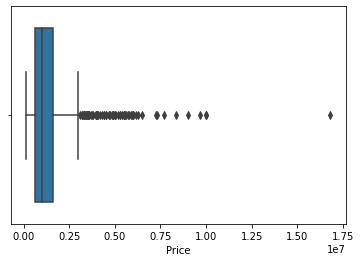

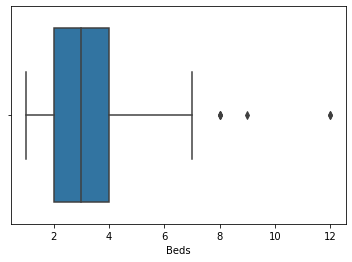

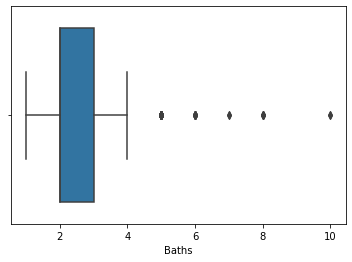

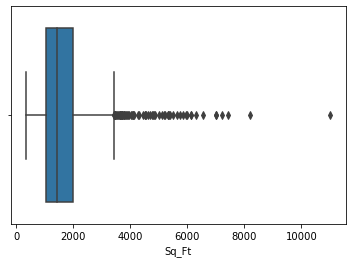

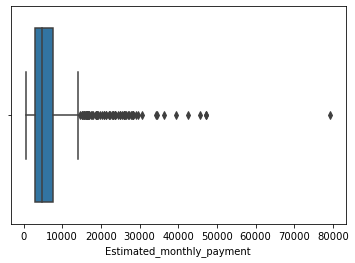

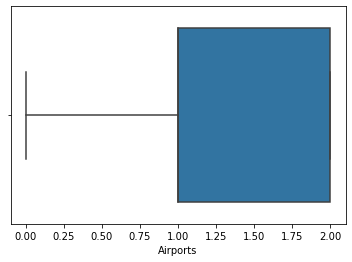

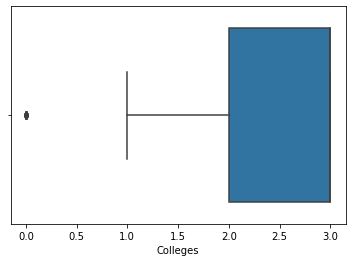

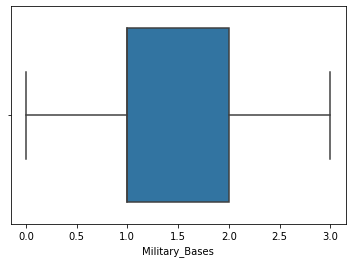

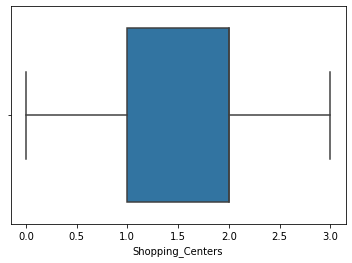

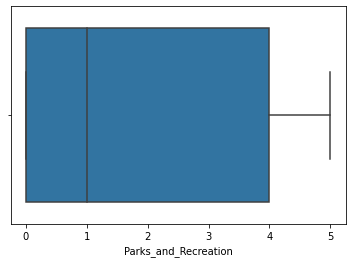

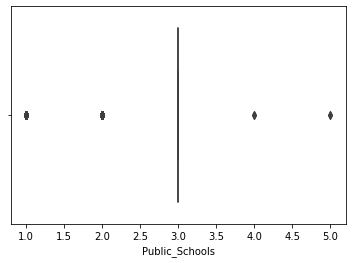

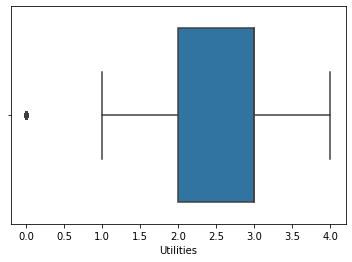

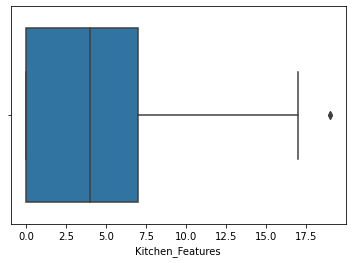

In [48]:
# Boxplot - to check outliers for all numerical columns
for col in numeric_cols:
    df = homes[col]
    plt.figure()
    sns.boxplot(df)

In [49]:
# Removing outliers from all numerical columns
Q1 = homes.quantile(0.25)
Q3 = homes.quantile(0.75)
IQR = Q3 - Q1
no_outliers = homes[~((homes < (Q1 - 1.5 * IQR)) |(homes > (Q3 + 1.5 * IQR))).any(axis=1)]

In [50]:
print( "Number of records before removing outliers:", homes.shape)
print( "Number of records after removing outliers:", no_outliers.shape)
print(len(homes.index) - len(no_outliers.index),"Records removed")

Number of records before removing outliers: (1321, 26)
Number of records after removing outliers: (1004, 26)
317 Records removed


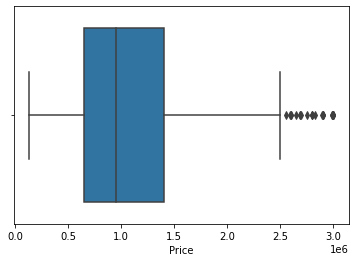

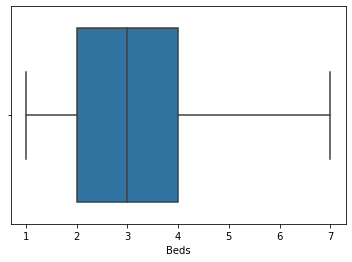

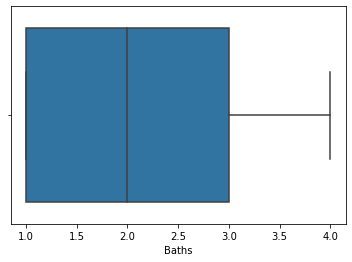

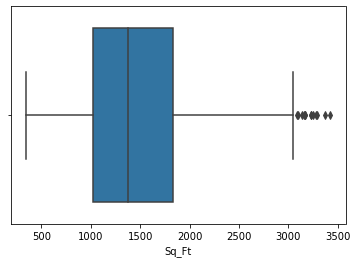

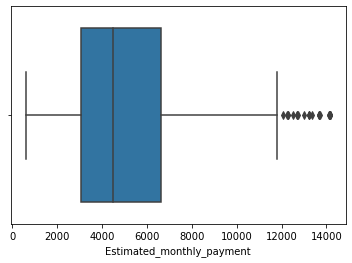

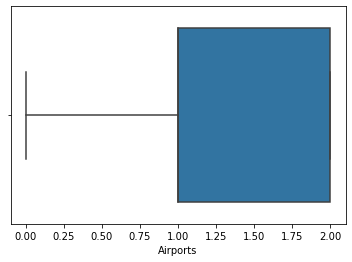

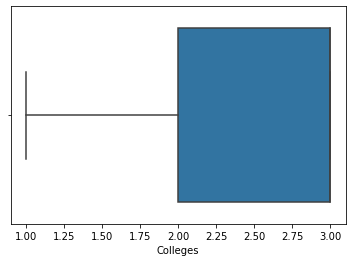

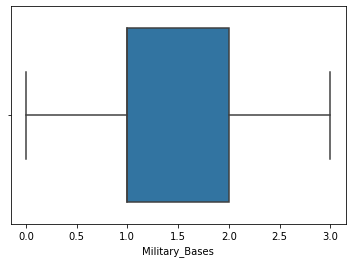

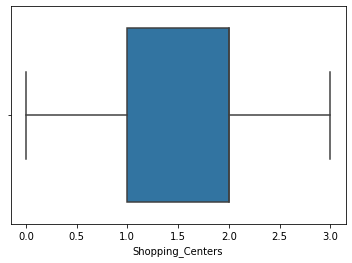

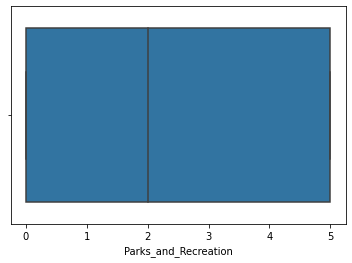

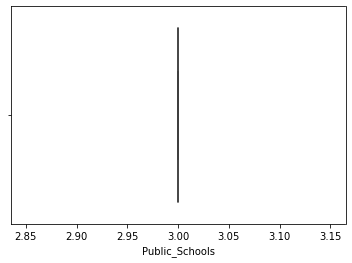

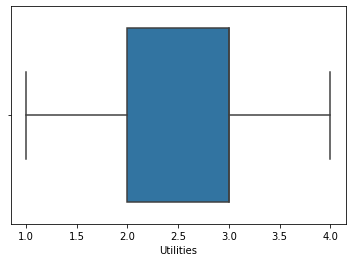

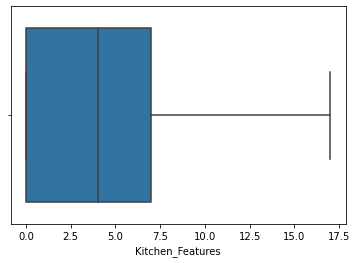

In [51]:
# Boxplot - after removing outliers for all numerical columns
for col in numeric_cols:
    df = no_outliers[col]
    plt.figure()
    sns.boxplot(df)

### <font color='RebeccaPurple'> Remove Outliers : Bedrooms and Bathrooms that are greater than 7

In [52]:
no_outliers = no_outliers[(no_outliers['Beds'] < 8 ) & (no_outliers['Baths'] < 8)]
no_outliers['Beds'].value_counts()

3    329
2    299
4    205
1    113
5     45
6      8
7      1
Name: Beds, dtype: Int64

In [53]:
no_outliers['Baths'].value_counts()

2    449
1    250
3    240
4     61
Name: Baths, dtype: Int64

In [54]:
no_outliers.describe()

,Price,Beds,Baths,Sq_Ft,Estimated_monthly_payment,Airports,Colleges,Military_Bases,Shopping_Centers,Parks_and_Recreation,Public_Schools,Utilities,Kitchen_Features
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,1.092430e+06,2.798000,2.112000,1485.711000,5159.386000,1.285000,2.600000,1.317000,1.568000,2.263000,3.0,2.661000,4.061000
std,5.752671e+05,1.088292,0.849811,597.634343,2716.907305,0.491952,0.666667,0.583825,1.011137,1.993943,0.0,0.654605,3.638477
min,1.299000e+05,1.000000,1.000000,350.000000,613.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.0,1.000000,0.000000
25%,6.490000e+05,2.000000,1.750000,1026.750000,3065.000000,1.000000,2.000000,1.000000,1.000000,0.000000,3.0,2.000000,0.000000
50%,9.500000e+05,3.000000,2.000000,1377.000000,4487.000000,1.000000,3.000000,1.000000,2.000000,2.000000,3.0,3.000000,4.000000
75%,1.399999e+06,4.000000,3.000000,1839.250000,6612.000000,2.000000,3.000000,2.000000,2.000000,5.000000,3.0,3.000000,7.000000
max,3.000000e+06,7.000000,4.000000,3425.000000,14169.000000,2.000000,3.000000,3.000000,3.000000,5.000000,3.0,4.000000,17.000000


#### <font color='RebeccaPurple'> Dropping Public_Schools column as there is no variation in the data

In [55]:
# All records have 3 public_schools, drop it as standard deviation is 0
no_outliers.drop("Public_Schools", axis = 1, inplace = True) 

In [57]:
check_null(no_outliers) # Check if dropping a column has affected induced any null value

No null values in the entire dataset.


### <font color ='RebeccaPurple'> Remove house prices that are greater than 10 Million and less than 100 Thousand

In [58]:
no_outliers = no_outliers[(no_outliers['Price'] > 100000) & (no_outliers['Price']) < 10000000]
no_outliers[['Price']].describe()

,Price
count,1.000000e+03
mean,1.092430e+06
std,5.752671e+05
min,1.299000e+05
25%,6.490000e+05
50%,9.500000e+05
75%,1.399999e+06
max,3.000000e+06


### <font color = 'RebeccaPurple '> Clean data scraped from AreaVibes.com

In [59]:
ratings = pd.read_csv('city_ratings.csv') # Read a file
ratings.fillna('B',inplace=True) # Place null values with a default reating 'B'
ratings.drop_duplicates(subset=ratings.columns,inplace = True) # Remove duplicates
ratings.drop(['Cost of Living','Amenities'],inplace=True,axis = 1) # These columns have same value in all the rows
ratings.columns = ratings.columns.str.replace(" ", "_") # Format columns
ratings.head()

,Unnamed:_0,Livability,Crime,Employment,Housing,Schools,User_Ratings
0,South San Francisco,69,C+,C+,C,D+,C+
1,San Mateo,75,C+,B+,C+,B-,B
2,Burlingame,81,D,A,B,A,A+
3,San Jose,67,D,C+,C-,D,C+
4,Palo Alto,80,C+,A+,C+,A+,B+


In [60]:
# Rename columns
ratings = ratings.rename(columns = {ratings.columns[0] : 'City' })
ratings = ratings.rename(columns = {ratings.columns[1] : 'Livability_Score' })
ratings.head()

,City,Livability_Score,Crime,Employment,Housing,Schools,User_Ratings
0,South San Francisco,69,C+,C+,C,D+,C+
1,San Mateo,75,C+,B+,C+,B-,B
2,Burlingame,81,D,A,B,A,A+
3,San Jose,67,D,C+,C-,D,C+
4,Palo Alto,80,C+,A+,C+,A+,B+


# <font color = 'Seagreen'> Part 3 : Organize Data

### <font color = 'Seagreen'> Merge Homes and Ratings dataset

In [61]:
# perform a left join on a shared column 'City'
master_df = no_outliers.merge(ratings,
                 how = 'left',
                 on = 'City')

In [62]:
master_df.head()

,Price,Beds,Baths,Sq_Ft,Address_Line_1,Agent_Name,Agent_Company,Listing_Type,Estimated_monthly_payment,Airports,...,Kitchen_Features,City,State,Zipcode,Livability_Score,Crime,Employment,Housing,Schools,User_Ratings
0,749000.0,1,1,935.0,1 Mandalay Place Unit 702,Elana Bennett,Coldwell Banker Realty,Condo,3537,1,...,0,South San Francisco,CA,94080,69,C+,C+,C,D+,C+
1,1398000.0,3,2,1500.0,306 Avalon Drive,Anthony Batshon,Batshon Real Estate Company,House,6603,1,...,2,South San Francisco,CA,94080,69,C+,C+,C,D+,C+
2,949000.0,2,1,800.0,709 W Orange Ave,Daniel Choi,Coldwell Banker Realty,House,4482,1,...,0,South San Francisco,CA,94080,69,C+,C+,C,D+,C+
3,1805000.0,4,3,2000.0,814 Miller Ave,Maryann Ernst,KW Peninsula Estates,House,8525,1,...,2,South San Francisco,CA,94080,69,C+,C+,C,D+,C+
4,798000.0,2,2,1252.0,45 Appian Way A,Rebecca Molano,Redfin,House,3769,1,...,0,South San Francisco,CA,94080,69,C+,C+,C,D+,C+


### <font color = 'Seagreen'> Re-arrange the columns

In [63]:
master_df.columns # Final column list of cleaned dataset

Index(['Price', 'Beds', 'Baths', 'Sq_Ft', 'Address_Line_1', 'Agent_Name',
       'Agent_Company', 'Listing_Type', 'Estimated_monthly_payment',
       'Airports', 'Colleges', 'Military_Bases', 'Shopping_Centers',
       'Parks_and_Recreation', 'Utilities', 'HOA', 'Parking', 'Garage', 'Pool',
       'Laundry', 'Pets_Allowed', 'Kitchen_Features', 'City', 'State',
       'Zipcode', 'Livability_Score', 'Crime', 'Employment', 'Housing',
       'Schools', 'User_Ratings'],
      dtype='object')

In [64]:
master_df = master_df[['City',
                       'Livability_Score',
                       'Listing_Type',
                       'Price',
                       'Sq_Ft',
                       'Beds',
                       'Baths',
                       'Estimated_monthly_payment',
                       'Crime', 
                       'Employment', 
                       'Housing',
                       'Schools', 
                       'User_Ratings',
                       'Address_Line_1',
                       'Agent_Name',
                       'Agent_Company',
                       'Airports', 
                       'Colleges', 
                       'Military_Bases', 
                       'Shopping_Centers',
                       'Parks_and_Recreation', 
                       'Utilities',
                       'Kitchen_Features',
                       'HOA', 
                       'Parking',
                       'Garage', 
                       'Pool', 
                       'Laundry', 
                       'Pets_Allowed', 
                       'State',
                       'Zipcode']]
master_df.head() # A peek at cleaned dataset

,City,Livability_Score,Listing_Type,Price,Sq_Ft,Beds,Baths,Estimated_monthly_payment,Crime,Employment,...,Utilities,Kitchen_Features,HOA,Parking,Garage,Pool,Laundry,Pets_Allowed,State,Zipcode
0,South San Francisco,69,Condo,749000.0,935.0,1,1,3537,C+,C+,...,3,0,No,Yes,Yes,No,No,No,CA,94080
1,South San Francisco,69,House,1398000.0,1500.0,3,2,6603,C+,C+,...,1,2,Yes,No,No,Yes,No,No,CA,94080
2,South San Francisco,69,House,949000.0,800.0,2,1,4482,C+,C+,...,4,0,No,Yes,Yes,No,No,No,CA,94080
3,South San Francisco,69,House,1805000.0,2000.0,4,3,8525,C+,C+,...,2,2,No,No,No,No,Yes,No,CA,94080
4,South San Francisco,69,House,798000.0,1252.0,2,2,3769,C+,C+,...,2,0,No,No,No,No,Yes,No,CA,94080


In [65]:
master_df.dtypes # Data types of cleaned dataset

City                          object
Livability_Score               int64
Listing_Type                  object
Price                        float64
Sq_Ft                        float64
Beds                           Int32
Baths                          Int32
Estimated_monthly_payment      Int32
Crime                         object
Employment                    object
Housing                       object
Schools                       object
User_Ratings                  object
Address_Line_1                object
Agent_Name                    object
Agent_Company                 object
Airports                       int64
Colleges                       int64
Military_Bases                 int64
Shopping_Centers               int64
Parks_and_Recreation           int64
Utilities                      int64
Kitchen_Features               int64
HOA                           object
Parking                       object
Garage                        object
Pool                          object
L

In [68]:
master_df.describe() # Statistics of cleaned dataset

,Livability_Score,Price,Sq_Ft,Beds,Baths,Estimated_monthly_payment,Airports,Colleges,Military_Bases,Shopping_Centers,Parks_and_Recreation,Utilities,Kitchen_Features
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,65.310000,1.092430e+06,1485.711000,2.798000,2.112000,5159.386000,1.285000,2.600000,1.317000,1.568000,2.263000,2.661000,4.061000
std,10.362494,5.752671e+05,597.634343,1.088292,0.849811,2716.907305,0.491952,0.666667,0.583825,1.011137,1.993943,0.654605,3.638477
min,53.000000,1.299000e+05,350.000000,1.000000,1.000000,613.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,53.000000,6.490000e+05,1026.750000,2.000000,1.750000,3065.000000,1.000000,2.000000,1.000000,1.000000,0.000000,2.000000,0.000000
50%,67.000000,9.500000e+05,1377.000000,3.000000,2.000000,4487.000000,1.000000,3.000000,1.000000,2.000000,2.000000,3.000000,4.000000
75%,75.000000,1.399999e+06,1839.250000,4.000000,3.000000,6612.000000,2.000000,3.000000,2.000000,2.000000,5.000000,3.000000,7.000000
max,85.000000,3.000000e+06,3425.000000,7.000000,4.000000,14169.000000,2.000000,3.000000,3.000000,3.000000,5.000000,4.000000,17.000000


In [69]:
master_df.to_csv("homes_clean_data.csv", index = False, header = True) # Export csv file to disk